In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano

In [2]:
a=np.arange(3)

In [3]:
P=np.array([[0.8,0.1,0.1],[0.05,0.9,0.05],[0.15,0.15,0.7]])
P

array([[ 0.8 ,  0.1 ,  0.1 ],
       [ 0.05,  0.9 ,  0.05],
       [ 0.15,  0.15,  0.7 ]])

In [4]:
P[:,:-1]

array([[ 0.8 ,  0.1 ],
       [ 0.05,  0.9 ],
       [ 0.15,  0.15]])

In [5]:
def unconditionalProbability(Ptrans):
   """Compute the unconditional probability for the states of a
   Markov chain."""

   m = Ptrans.shape[0]

   P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

   I = np.eye(m)
   U = np.ones((m, m))
   u = np.ones(m)

   return np.linalg.solve((I - P + U).T, u)


In [6]:
# equilibrium probabilities
PU = unconditionalProbability(P[:,:-1])
print(PU)
print(np.sum(PU))

[ 0.27272727  0.54545455  0.18181818]
1.0


In [9]:
"""
Pt = tt.dmatrix('Pt')
P = tt.column_stack((Pt, 1. - Pt.sum(axis=1)))
m = Pt.shape[0]
PA = tt.slinalg.Solve((tt.eye(m) - P + tt.ones(m,m)).T, tt.ones(m))
equilibrium_probability = theano.function(Pt,PA)
"""

"\nPt = tt.dmatrix('Pt')\nP = tt.column_stack((Pt, 1. - Pt.sum(axis=1)))\nm = Pt.shape[0]\nPA = tt.slinalg.Solve((tt.eye(m) - P + tt.ones(m,m)).T, tt.ones(m))\nequilibrium_probability = theano.function(Pt,PA)\n"

In [7]:
# create a sample
firstpoint = np.random.choice(3, 1, p=PU)
print(firstpoint)
sample = [firstpoint[0]]
sample
for i in range(1,1000):
    sample = np.concatenate((sample,np.random.choice(3,1,p=P[sample[-1]])))

[1]


(array([ 1.255,  0.   ,  0.   ,  0.   ,  0.   ,  2.965,  0.   ,  0.   ,
         0.   ,  0.78 ]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

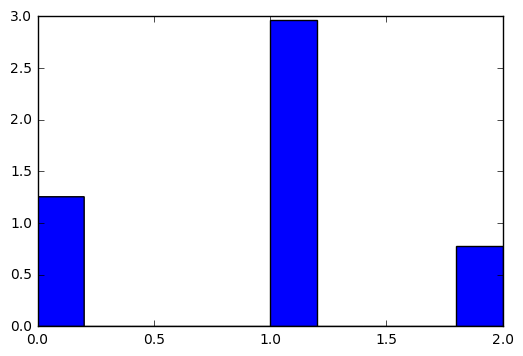

In [8]:
plt.hist(sample, normed=True)

(-0.2, 2.2)

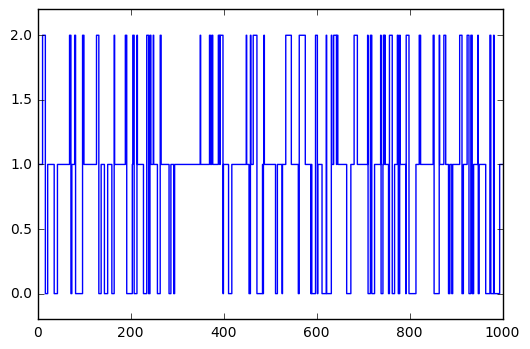

In [9]:
plt.plot(sample[:1000], drawstyle='steps-mid')
plt.ylim((-0.2,2.2))

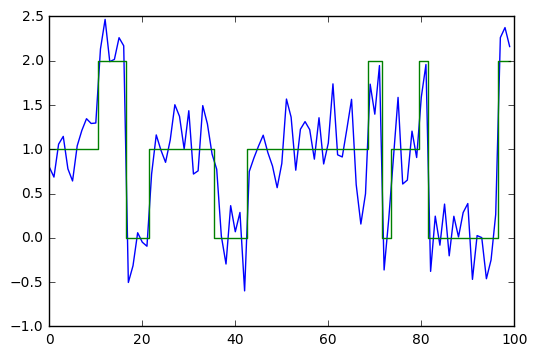

In [10]:
measurement = sample + 0.3*np.random.randn(1000)
plt.plot(measurement[:100])
plt.plot(sample[:100], drawstyle='steps-mid')

In [11]:
# now we want to create a P matrix that reflects the states
PT = np.tile(P.T,(10,1,1))
PT

array([[[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]],

       [[ 0.8 ,  0.05,  0.15],
        [ 0.1 ,  0.9 ,  0.15],
        [ 0.1 ,  0.05,  0.7 ]]])

In [12]:
PS = np.choose(sample[:10],PT.T).T
PS

array([[ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05],
       [ 0.05,  0.9 ,  0.05]])

In [13]:
sample[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [30]:
import pymc3 as pm
import theano.tensor as tt
# Two state model for simplicity.
N_states = 3
N_chain = len(sample)

# Transition probability stochastic
theta = np.ones((N_states,N_states)) + 1.

In [22]:
class HMMStatesN(pm.Discrete):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states-1)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states-1)
    
    """

    def __init__(self, PA=None, P=None,
                 *args, **kwargs):
        super(HMMStatesN, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.mean = 0.

    def logp(self, x):
        P = self.P
        PA = self.PA
        
        # calculate equilibrium
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        #P = tt.switch(x[:-1],P1,P2)
        length = x.shape[0]
        PT = tt.tile(P.T,(length-1,1,1))

        PS = tt.choose(x[:-1],PT.T).T
        
        x_i = x[1:]
        ou_like = pm.Categorical.dist(PS).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)


In [33]:
from scipy import optimize
with pm.Model() as model:
    # N_states state model
    #P = tt.stack( [pm.Dirichlet('P_'+str(i), a=np.ones(N_states)) for i in range(N_states)] )
    
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    
    PA = pm.Dirichlet('PA', a=np.ones(N_states)+1.)
    
    states = HMMStatesN('states',PA=PA, P=P, observed=sample)
    
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    step = pm.Metropolis()
    trace = pm.sample(10000, start=start, step=step)


Optimization terminated successfully.
         Current function value: 509.397480
         Iterations: 2
         Function evaluations: 172


100%|██████████| 10000/10000 [00:09<00:00, 1024.28it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1226d6f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1245c2cc0>]], dtype=object)

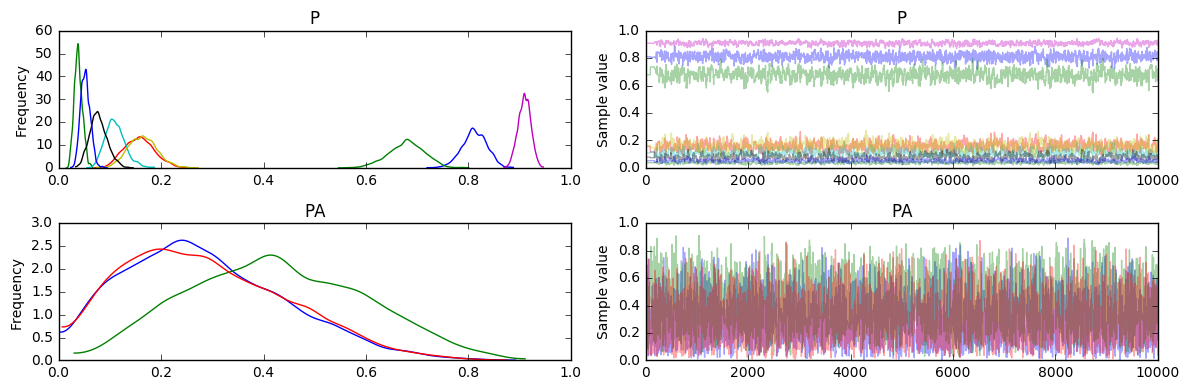

In [34]:
%matplotlib inline
pm.traceplot(trace)